# **Implement CNNs with CIFAR 10. Training and Evaluating on CIFAR 10.**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes

100%|██████████| 170M/170M [00:04<00:00, 35.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_log = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    training_log.append(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 1.2942
Epoch 2, Loss: 0.8910
Epoch 3, Loss: 0.6990
Epoch 4, Loss: 0.5433
Epoch 5, Loss: 0.3918
Epoch 6, Loss: 0.2556
Epoch 7, Loss: 0.1601
Epoch 8, Loss: 0.1080
Epoch 9, Loss: 0.0671
Epoch 10, Loss: 0.0714


In [5]:
# Evaluating the Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

# Save Training Log
with open('training_log.txt', 'w') as f:
    f.writelines('\n'.join(training_log))


Accuracy: 72.88%


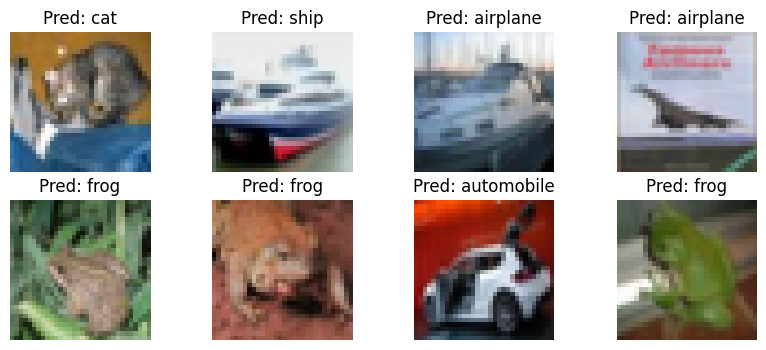

In [6]:
# Visualizing Some Test Predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(torch.permute(img, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Show Images with Predictions
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i])
    plt.title(f"Pred: {classes[predicted[i].item()]}")
    plt.axis('off')
plt.show()

# **Tuning hyper-parameters: batch size, optimizer, learning rate, ...**

In [7]:
from itertools import product

# Define hyperparameter combinations
batch_sizes = [32, 64]
learning_rates = [0.001, 0.0005]
optimizers = ['Adam', 'SGD']
results = []

# Loop over all combinations
for batch_size, lr, opt in product(batch_sizes, learning_rates, optimizers):
    print(f"\nTuning with Batch Size={batch_size}, LR={lr}, Optimizer={opt}")

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    model = CNN().to(device)

    # Define Optimizer
    if opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Train
    num_epochs = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    results.append((batch_size, lr, opt, accuracy))

# The Best Results
best_result = max(results, key=lambda x: x[3])
print("\nBest Hyperparameters:")
print(f"Batch Size: {best_result[0]}, Learning Rate: {best_result[1]}, Optimizer: {best_result[2]}, Accuracy: {best_result[3]:.2f}%")



Tuning with Batch Size=32, LR=0.001, Optimizer=Adam
Epoch 1, Loss: 1.2567
Epoch 2, Loss: 0.8586
Epoch 3, Loss: 0.6748
Epoch 4, Loss: 0.5166
Epoch 5, Loss: 0.3660
Test Accuracy: 72.64%

Tuning with Batch Size=32, LR=0.001, Optimizer=SGD
Epoch 1, Loss: 1.9240
Epoch 2, Loss: 1.4489
Epoch 3, Loss: 1.2688
Epoch 4, Loss: 1.1553
Epoch 5, Loss: 1.0561
Test Accuracy: 62.32%

Tuning with Batch Size=32, LR=0.0005, Optimizer=Adam
Epoch 1, Loss: 1.3081
Epoch 2, Loss: 0.9235
Epoch 3, Loss: 0.7430
Epoch 4, Loss: 0.5967
Epoch 5, Loss: 0.4568
Test Accuracy: 72.95%

Tuning with Batch Size=32, LR=0.0005, Optimizer=SGD
Epoch 1, Loss: 2.0279
Epoch 2, Loss: 1.6483
Epoch 3, Loss: 1.4572
Epoch 4, Loss: 1.3390
Epoch 5, Loss: 1.2572
Test Accuracy: 55.60%

Tuning with Batch Size=64, LR=0.001, Optimizer=Adam
Epoch 1, Loss: 1.2627
Epoch 2, Loss: 0.8690
Epoch 3, Loss: 0.6849
Epoch 4, Loss: 0.5229
Epoch 5, Loss: 0.3640
Test Accuracy: 74.28%

Tuning with Batch Size=64, LR=0.001, Optimizer=SGD
Epoch 1, Loss: 2.0638
E